# Predicting Claim Denials and Reason Codes

Client is a US based <b>R</b>evenue <b>C</b>ycle <b>M</b>anagement<b>(RCM)</b> company. On an average, they experience about 10% of the claims getting completely denied. This results in a huge manual re-work on those denied claims. 

### Business Challenge

- In healthcare, a lot of rework is done due to claim denials. The reason being the denials dependent on multiple factors which are difficult to identify manually.
- Client wanted a solution  which predicts the likelihood of a claim getting denied.
- Client also needed to identify the causes of denials for the claims getting denied.

### Benefits

- Saved the client from re-work on denied claims.
- The solution helped in reducing cost required to manually perform the process. It also saved a lot of time
- Predicting reasons for rejection allowed client to make corrections in the denied claims and resubmit for a better approval rate.


In [1]:
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os

%matplotlib inline
sns.set(color_codes=True)
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv("D:\DataSciencePOC's\Claim_Denial\data\claims_preprocessed.csv")
fully_denied = pd.read_csv("D:\DataSciencePOC's\Claim_Denial\data\FDC_cleaned.csv")

In [3]:
data.columns[1:]

Index(['member_id', 'subscriber_id', 'city', 'county', 'provider_id',
       'provider_type', 'provider_type2', 'claim_id', 'claim_sequence',
       'line_of_business', 'age', 'gender', 'claim_sub_type',
       'network_indicator1', 'place_of_service', 'procedure_code',
       'diagnosis_code', 'claim_from_date', 'claim_to_date', 'amount_on_claim',
       'amount_considered', 'amount_allowed', 'amount_dis_allowed',
       'amount_paid', 'dedcutible', 'copay', 'coinsurance', 'rejection_code',
       'rejection_reason', 'network_indicator2', 'pre_auth_indicator',
       'status', 'combination_id', 'ICD_10'],
      dtype='object')

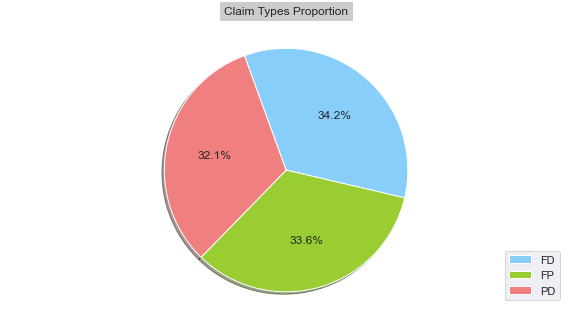

In [4]:
temp = data['status'].value_counts()
plt.figure(figsize=(10,5))
labels = temp.index
sizes = temp
colors = ['lightskyblue','yellowgreen', 'lightcoral', 'mediumpurple', 'silver','burlywood', 'salmon',  'chocolate', 'orchid']
explode = [0,0]
 
# Plot
plt.pie(sizes, explode=None, labels=['']*len(labels), colors=colors,
        autopct='%1.1f%%', shadow=True, startangle = 110, counterclock = False)
plt.title('Claim Types Proportion', bbox={'facecolor':'0.8', 'pad':5}, y =1.05)
plt.legend(labels, loc="lower right")
plt.axis('equal')
plt.show()

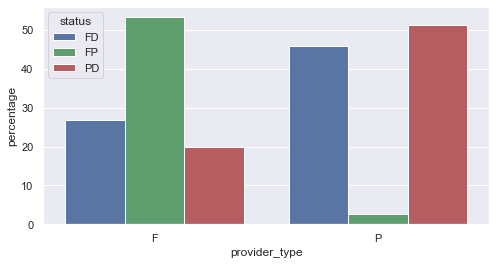

In [5]:
occupation_counts = (data.groupby(['provider_type'])['status']
                     .value_counts(normalize=True)
                     .rename('percentage')
                     .mul(100)
                     .reset_index()
                     .sort_values('status'))

plt.subplots(figsize=(8,4))
p = sns.barplot(x="provider_type", y="percentage", hue="status", data=occupation_counts, palette= {"FD": "b", "PD": "r", "FP": "g"})



**Inference:** It is clear that when the provider_type is F(Facility) there are more chances of getting paid fully than P(Practitioner)

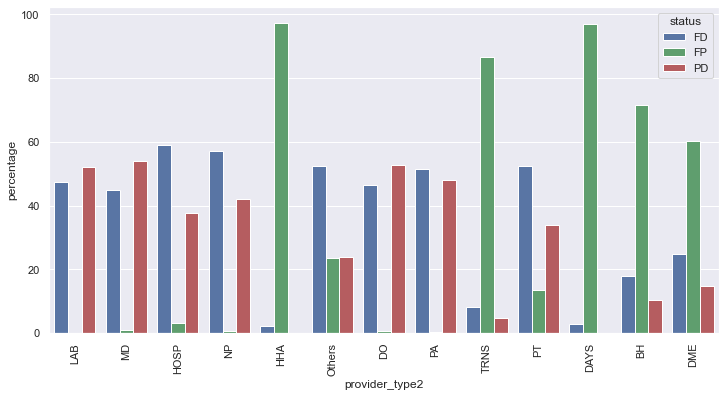

In [6]:
occupation_counts = (data.groupby('provider_type2')['status']
                     .value_counts(normalize=True)
                     .rename('percentage')
                     .mul(100)
                     .reset_index()
                     .sort_values('status'))

plt.subplots(figsize=(12,6))

p = sns.barplot(x="provider_type2", y="percentage", hue="status", data=occupation_counts, palette= {"FD": "b", "PD": "r", "FP": "g"})
plt.xticks(rotation = 90)
plt.show()


**Inference** : 90% of HHA (Home Health Aid) claims are fully paid. There seems to be a great correlation between the denial and type of claim

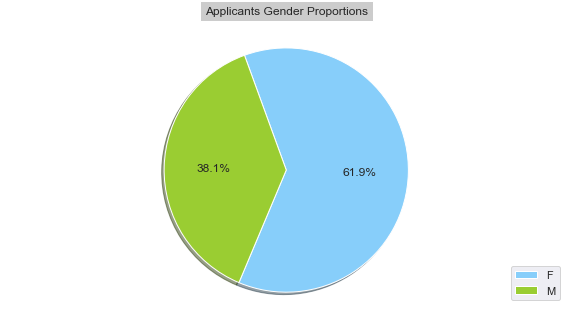

In [7]:
temp = data['gender'].value_counts()
plt.figure(figsize=(10,5))
labels = temp.index
sizes = temp
colors = ['lightskyblue','yellowgreen', 'lightcoral', 'mediumpurple', 'silver','burlywood', 'salmon',  'chocolate', 'orchid']
explode = [0,0]
 
# Plot
plt.pie(sizes, explode=explode, labels=['']*len(labels), colors=colors,
        autopct='%1.1f%%', shadow=True, startangle = 110, counterclock = False)
plt.title('Applicants Gender Proportions', bbox={'facecolor':'0.8', 'pad':5}, y =1.05)
plt.legend(labels, loc="lower right")
plt.axis('equal')
plt.show()

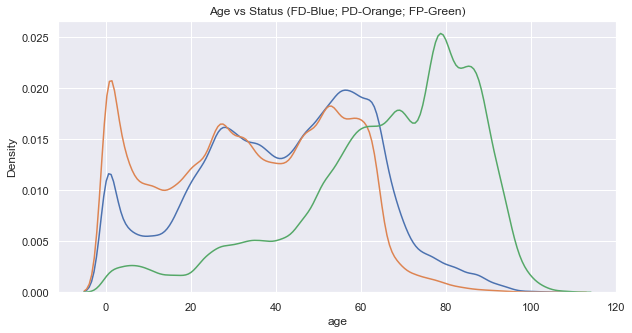

In [8]:
plt.subplots(figsize=(10,5))
sns.kdeplot(data.age[data.status == 'FD'], legend = False)
sns.kdeplot(data.age[data.status == 'PD'], legend = False)
sns.kdeplot(data.age[data.status == 'FP'], legend = False)
plt.title("Age vs Status (FD-Blue; PD-Orange; FP-Green)")
plt.show()

**Inference** : Higher the age, higher the probability of getting an FP

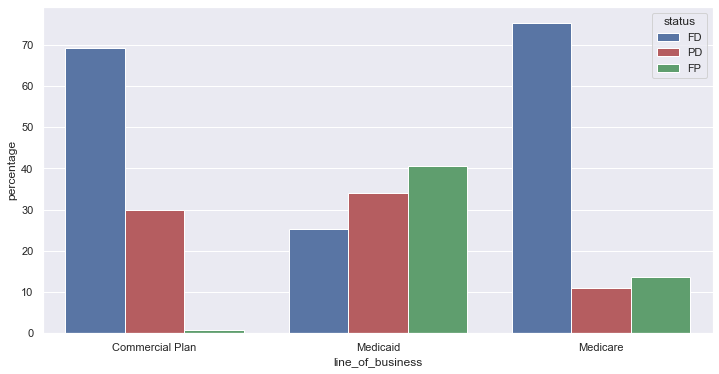

In [9]:
occupation_counts = (data.groupby(['line_of_business'])['status']
                     .value_counts(normalize=True)
                     .rename('percentage')
                     .mul(100)
                     .reset_index()
                     .rename(columns = {"index": "line_of_business", "ICD_10": "percentage"}))

plt.subplots(figsize=(12,6))
p = sns.barplot(x="line_of_business", y="percentage", hue = 'status', data=occupation_counts, palette= {"FD": "b", "PD": "r", "FP": "g"})
plt.show()


**Inference** Medicaid claims have better chances of getting fully paid than others

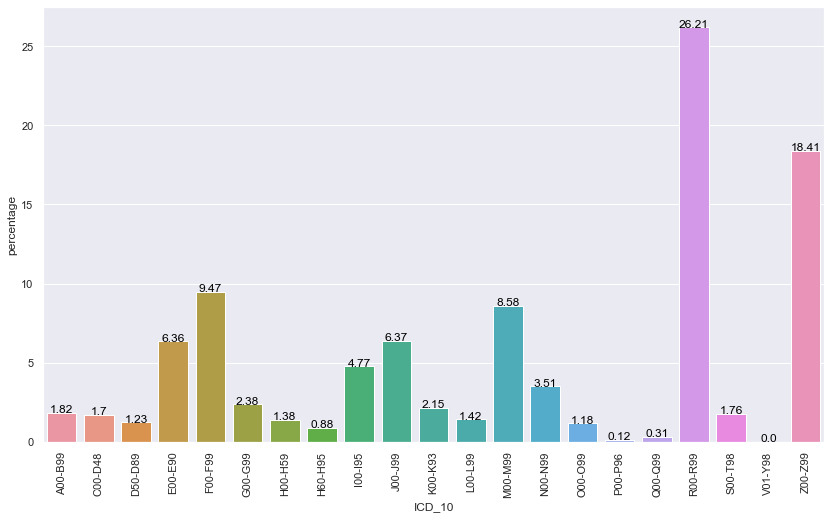

In [10]:
occupation_counts = (data.ICD_10
                     .value_counts(normalize=True)
                     .rename('percentage')
                     .mul(100)
                     .reset_index()
                     .rename(columns = {"index": "ICD_10", "ICD_10": "percentage"})
                     .sort_values("ICD_10")
                     .reset_index()
                     .drop('index', axis = 1))

plt.subplots(figsize=(14,8))
p = sns.barplot(x="ICD_10", y="percentage", data=occupation_counts)
plt.xticks(rotation = 90)

for index, row in occupation_counts.iterrows():
     p.text(index,row.percentage, round(row.percentage,2), color='black', ha="center")

**Inference**: R00-R99 & Z00-Z99 ICD claims are mostly denied

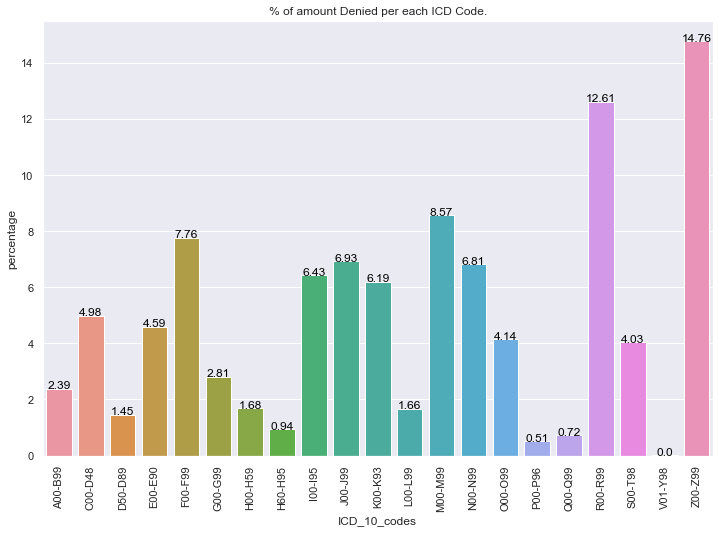

In [11]:
plt.subplots(figsize=(12,8))
temp = data.groupby('ICD_10')['amount_dis_allowed'].sum().reset_index()
temp['percentage'] = temp.amount_dis_allowed/sum(temp.amount_dis_allowed)*100
p = sns.barplot(temp.ICD_10, temp.percentage)
plt.xticks(rotation = 90)
plt.xlabel('ICD_10_codes')
plt.ylabel('percentage')
plt.title('% of amount Denied per each ICD Code.')

for index, row in temp.iterrows():
    p.text(row.name,row.percentage, round(row.percentage,2), color='black', ha="center")

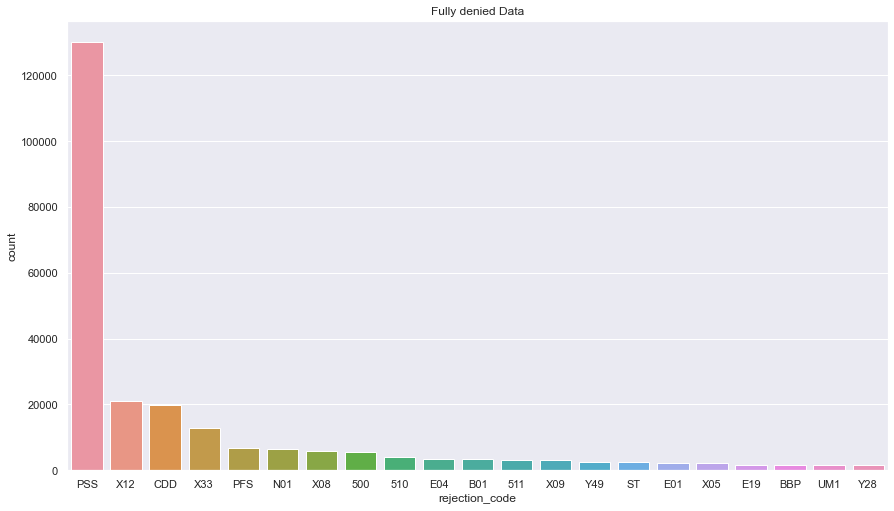

In [12]:
sns.set(rc={'figure.figsize':(14.7,8.27)})
k = fully_denied['rejection_code'].value_counts()
t = fully_denied[ fully_denied['rejection_code'].isin(k[:21].index)]
sns.countplot(x="rejection_code", data=t, order=t.rejection_code.value_counts().index)
plt.title('Fully denied Data')
plt.show()

In [13]:
claim_denial_reasons_top20 = pd.read_csv("D:\DataSciencePOC's\Claim_Denial\data\Claim_Denial_Reason_Codes_Top20.csv")
claim_denial_reasons_top20.columns
rc_vc = pd.DataFrame(t.rejection_code.value_counts()).reset_index()
rc_vc.columns = ['Code', 'Value_Counts']

In [14]:
(rc_vc.merge(claim_denial_reasons_top20, on='Code')).drop(columns=['Value_Counts'])

,Code,Description,CARC_code
0,PSS,The charge exceeds the allowable amount for th...,45
1,X12,Code only more extensive service same site,b15
2,CDD,This claim is a duplicate of a previously subm...,18
3,X33,Supporting information for OCE /Mutually exclu...,146
4,PFS,The charge exceeds the allowable amount for th...,45
5,N01,Procedure denied incidental to a procedure on ...,97
6,X08,Services essential to procedure are not coded....,234
7,500,Submitting IPA is not related to member's IPA,NaN
8,510,Service Area Override,NaN
9,E04,Never Event Service not covered . Subscriber ...,NaN


## Confusion Matrix - Multiclass model

In [15]:
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes=["Fully Denied", "Partially Denied", "Fully Paid"], title="",
                          cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title('Confusion matrix ' +title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('Actual')
    plt.xlabel('Predicted')

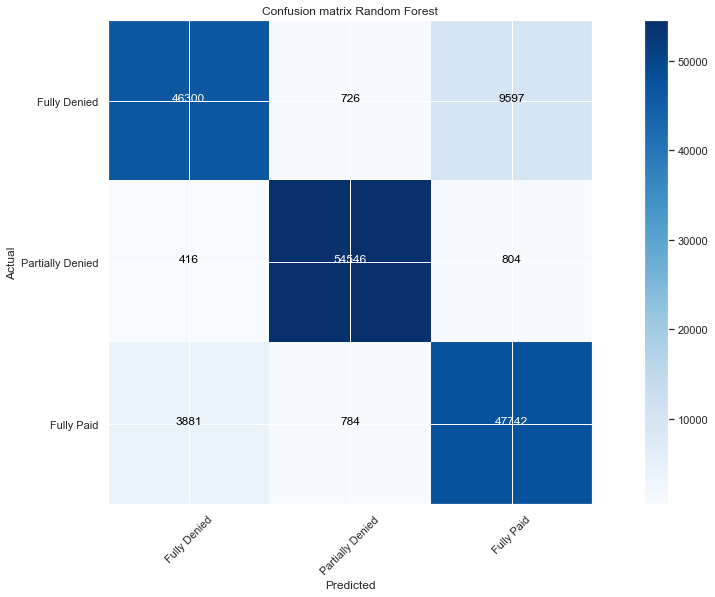

In [16]:
best_model = np.array([[46300,   726,  9597],
       [  416, 54546,   804],
       [ 3881,   784, 47742]])
plt.figure()
plot_confusion_matrix(best_model, title = 'Random Forest')

                    precision    recall  f1-score   support

    Fully Denied       0.92      0.82      0.86     56623
    Partially Denied   0.97      0.98      0.98     55766
    Fully Paid         0.82      0.91      0.86     52407

     avg / total       0.90      0.90      0.90    164796

## Demo

In [17]:
%matplotlib inline
import os
import json
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot  as plt
import joblib
from matplotlib.colors import from_levels_and_colors

In [18]:
header = {'Content-Type': 'application/json', 'Accept': 'application/json'}

In [19]:
fully_denied = pd.read_csv("D:\DataSciencePOC's\Claim_Denial\data\FDC_cleaned.csv")
partially_denied = pd.read_csv("D:\DataSciencePOC's\Claim_Denial\data\PDC_cleaned.csv")
fully_paid = pd.read_csv("D:\DataSciencePOC's\Claim_Denial\data\FPC_cleaned.csv")

In [20]:
fully_denied['combination_id'] = fully_denied['claim_id'].combine(fully_denied['claim_sequence'], lambda s1, s2: str(s1)+'_'+ str(s2))
partially_denied['combination_id'] = partially_denied['claim_id'].combine(partially_denied['claim_sequence'], lambda s1, s2: str(s1)+'_'+ str(s2))
fully_paid['combination_id'] = fully_paid['claim_id'].combine(fully_paid['claim_sequence'], lambda s1, s2: str(s1)+'_'+ str(s2))

In [21]:
def get_member_data(MEM_ID):
    json_pd = partially_denied.loc[partially_denied.combination_id.isin(MEM_ID)].to_json()
    json_fd = fully_denied.loc[fully_denied.combination_id.isin(MEM_ID)].to_json()
    json_fp = fully_paid.loc[fully_paid.combination_id.isin(MEM_ID)].to_json()
    p_data = json.dumps({'partially_denied': json_pd,
             'fully_denied': json_fd,
             'fully_paid': json_fp})
    return p_data

In [22]:
start_row = 0
end_row = 10
number_of_outputs = 10

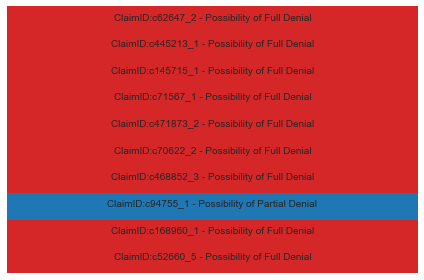

In [23]:
df = joblib.load(r"D:\DataSciencePOC's\Claim_Denial\data\combination_id_new.pkl")
df_ls = df[start_row : end_row]
try:
    p_data = get_member_data(df_ls)
    resp = requests.post("http://127.0.0.1:8002/predict", data = p_data, headers= header)
    pred_result = resp.json()
    pred_result_list = []
    #print(len(pred_result.items()))
    for i,j in pred_result.items():
        pred_result_list.append(j)
    pred_result_list = (np.array([pred_result_list])).reshape(len(pred_result_list),1)
    cmap, norm = from_levels_and_colors([0,1,2,3],['tab:green','tab:blue', 'tab:red'])
    img = plt.imshow(pred_result_list, interpolation='nearest', cmap=cmap, norm=norm, aspect='auto')
    plt.axis('off')
    for i, j in enumerate(pred_result_list):
            plt.text(0, i, "ClaimID:{} - No Denial".format(df_ls[i]) if j == 0  else ("ClaimID:{} - Possibility of Partial Denial".format(df_ls[i]) if j == 1 else "ClaimID:{} - Possibility of Full Denial".format(df_ls[i])) ,horizontalalignment="center")
    plt.tight_layout()
    start_row = end_row
    end_row = end_row + number_of_outputs
    #print(start_row, end_row)
except:
    print("EOF: Run the previous cell")

## Demo - Rejection Reason

In [24]:
df_rcp = pd.read_csv(r"D:\DataSciencePOC's\Claim_Denial\data\rejection_codes_top10.csv")
def get_test_member_data_rcp(MEM_ID):
    json_rcp = df_rcp.loc[df_rcp.combination_id.isin(MEM_ID)].to_json()
    p_data = json.dumps({'rcp_df': json_rcp})
    return p_data
start_row = 0
end_row = 10
number_of_outputs = 10
rejection_reasons = {0 : '500', 1 : 'CDD', 2 : 'PFS', 3 : 'N01', 4 : 'PSS', 5 : 'X12', 6 : 'X33', 7 : 'E01', 8 : 'X08',
       9 : 'E04'}
df = joblib.load(r'data/combination_id_pickle.pkl')
df_ls = df.reset_index(drop=True)

In [25]:
df_rcp.rejection_code.value_counts()

PSS    627152
E01     33670
X12     28498
PFS     22142
CDD     19490
X33     12030
N01     11613
E04     11109
X08      5860
500      4901
Name: rejection_code, dtype: int64

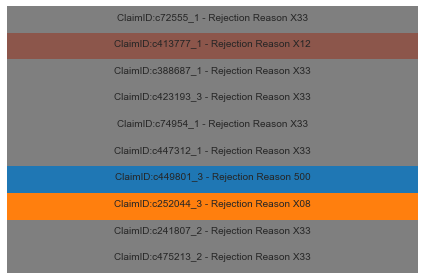

In [26]:
import joblib
import json
import requests
#df_ls = df.reset_index(drop=True)
df_ls = df[start_row : end_row]
df_ls = df_ls.reset_index(drop=True)
rcp_data = get_test_member_data_rcp(df_ls)
resp = requests.post("http://127.0.0.1:8002/predict_rcp", data = rcp_data, headers= header)
pred_result = resp.json()
pred_result_list = []
#print(len(pred_result.items()))
for i,j in pred_result.items():
    pred_result_list.append(j)
pred_result_list = (np.array([pred_result_list])).reshape(len(pred_result_list),1)
cmap, norm = from_levels_and_colors([0,1,2,3,4,5,6,7,8,9,10],['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:olive', 'tab:brown', 'tab:gray', 
                                                              'tab:blue', 'tab:orange', 'tab:green'])
img = plt.imshow(pred_result_list, interpolation='nearest', cmap=cmap, norm=norm, aspect='auto')
plt.axis('off')
for i, j in enumerate(pred_result_list):
        plt.text(0, i, "ClaimID:{} - Rejection Reason {}".format(df_ls[i], rejection_reasons[j[0]]),horizontalalignment="center" )
plt.tight_layout()
start_row = end_row
end_row = end_row + number_of_outputs